<a href="https://colab.research.google.com/github/jay-jojo-cheng/deep-tsundoku/blob/master/notebooks/donut_torchscript_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, we install 🤗 Transformers, Datasets and SentencePiece (the latter is used for tokenization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 5.0 MB/s 
     |████████████████████████████████| 163 kB 61.8 MB/s 


In [2]:
!pip install -q datasets sentencepiece

     |████████████████████████████████| 432 kB 5.3 MB/s 
     |████████████████████████████████| 1.3 MB 49.7 MB/s 
     |████████████████████████████████| 212 kB 71.5 MB/s 
     |████████████████████████████████| 115 kB 65.0 MB/s 
     |████████████████████████████████| 127 kB 71.3 MB/s 


## Load image

In [3]:
!gdown 1MYUzZM4bHtSFjgW_QWSG8MOPFEcizxo_

Downloading...
From: https://drive.google.com/uc?id=1MYUzZM4bHtSFjgW_QWSG8MOPFEcizxo_
To: /content/book-spines-200.zip
100% 15.9M/15.9M [00:00<00:00, 191MB/s]


In [4]:
!unzip -q book-spines-200.zip

In [5]:
import pandas as pd
test_df = pd.read_csv("/content/book-spines-200/spines-200.csv", header = None, converters={0: str})
test_df.columns = ['id', 'title', 'author']

In [6]:
# we remove the double quotes since that will mess up the JSON later
import string
import re

def normalize_whitespace(str):
    str = str.strip()
    str = re.sub(r'\s+', ' ', str)
    return str


test_df['ground_truth'] = ['''{"gt_parse": {"text_sequence" : "%s"}}''' % (normalize_whitespace(title).translate(str.maketrans('', '', string.punctuation))) for title in test_df['title']]

In [7]:
# # THIS IS THE VERSION THAT USES BOTH TITLE AND AUTHOR WE DON'T USE THIS FOR NOW

# # we remove the double quotes since that will mess up the JSON later
# import string
# import re

# def normalize_whitespace(str):
#     str = str.strip()
#     str = re.sub(r'\s+', ' ', str)
#     return str


# test_df['ground_truth'] = ['''{"gt_parse": {"text_sequence" : "%s"}}''' % (normalize_whitespace(title).translate(str.maketrans('', '', string.punctuation))) for title in test_df['title']]

In [8]:
test_df

,id,title,author,ground_truth
0,001,Pride and Prejudice,Jane Austen,"{""gt_parse"": {""text_sequence"" : ""Pride and Pre..."
1,002,Nineteen Eighty-Four,George Orwell,"{""gt_parse"": {""text_sequence"" : ""Nineteen Eigh..."
2,003,Crime and Punishment,Fyodor Dostoevsky,"{""gt_parse"": {""text_sequence"" : ""Crime and Pun..."
3,004,Hamlet Macbeth Othello Romeo & Juliet,William Shakespeare,"{""gt_parse"": {""text_sequence"" : ""Hamlet Macbet..."
4,005,One Hundred Years of Solitude,Gabriel Garcia Márquez,"{""gt_parse"": {""text_sequence"" : ""One Hundred Y..."
...,...,...,...,...
195,196,Running in the Family,Michael Ondaatje,"{""gt_parse"": {""text_sequence"" : ""Running in th..."
196,197,From the Land of Green Ghosts A Burmese Odyssey,Pascal Khoo Thwe,"{""gt_parse"": {""text_sequence"" : ""From the Land..."
197,198,Chef,Jaspreet Singh,"{""gt_parse"": {""text_sequence"" : ""Chef""}}"
198,199,Where the Crawdads Sing,Delia Owens,"{""gt_parse"": {""text_sequence"" : ""Where the Cra..."


In [9]:
# new
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, Image

test_dataset = Dataset.from_dict({"image": "book-spines-200/" + test_df['id'] + ".jpg",
                            #  "asin": test_df['asin'],
                             "ground_truth": test_df['ground_truth']}).cast_column("image", Image())
dataset = DatasetDict({"test": test_dataset})

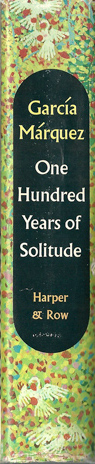

In [46]:
image = dataset['test'][4]['image']
# image = image.rotate(90, expand=True) # manually rotate for now
image

## Load model and processor

In [11]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("jay-jojo-cheng/donut-cover-author")
model = VisionEncoderDecoderModel.from_pretrained("jay-jojo-cheng/donut-cover-author", torchscript=True)

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [47]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 640, 480])


## Generate

Finally, we let the model autoregressively generate the structured data.

In [13]:
import torch

task_prompt = "<s_cover>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [43]:
traced_model = torch.jit.trace_module(mod=model,
                                      inputs={'generate' : [pixel_values, decoder_input_ids]} )

# # this is the old method used for text generation
# old_outputs = model.generate(pixel_values.to(device),
#                                decoder_input_ids=decoder_input_ids.to(device),
#                             #    max_length=model.decoder.config.max_position_embeddings,
#                             #    early_stopping=True,
#                             #    pad_token_id=processor.tokenizer.pad_token_id,
#                             #    eos_token_id=processor.tokenizer.eos_token_id,
#                             #    use_cache=True,
#                             #    num_beams=1,
#                             #    bad_words_ids=[[processor.tokenizer.unk_token_id]],
#                             #    return_dict_in_generate=True,
#                             #    output_scores=True,
#                          )

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1277: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  inputs_tensor, model_kwargs, model_input_name


In [38]:
torch.jit.save(traced_model, "traced_donut_model.pt")

In [48]:
outputs = traced_model.generate(pixel_values, decoder_input_ids)

In [49]:
import re

sequence = processor.batch_decode(outputs)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

One Hundred Years of Solitude


## **Convert to JSON**

We can convert the generated sequence to JSON if required:

In [16]:
processor.token2json(sequence)

{'text_sequence': 'Anna Kanemina Lao Tolstoy'}

## **Test loading the traced model**

In [51]:
test_loading_model = torch.jit.load("traced_donut_model.pt")

In [52]:
outputs = test_loading_model.generate(pixel_values, decoder_input_ids)

In [53]:
sequence = processor.batch_decode(outputs)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

One Hundred Years of Solitude
